# 18. Classify the map coverage errors (required) (sequence diagram not required)
- Classify each of the distinct polygons in the geographic area calculated in the previous use case with a possible error type (e.g., ghost precinct, gap between two precincts, etc.). 
- Store the associated data in the errors data structure for subsequent addition to the DB. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd

In [2]:
three_states = ["RI", "VA", "TX"]

In [3]:
va_empty = gpd.read_file("errors/VA_Empty.json")
ri_empty = gpd.read_file("errors/RI_Empty.json")
tx_empty = gpd.read_file("errors/TX_Empty.json")
empty_dict = {"va":va_empty, "ri":ri_empty, "tx":tx_empty}

In [4]:
path = "park_lake/park/"
parks = {}
for state in three_states:
    cur_path = path + state + "_Park.json"
    parks[state] = gpd.read_file(cur_path)

In [5]:
path = "park_lake/Water/"
waters = {}
for state in three_states:
    cur_path = path + state + "_Water.json"
    waters[state] = gpd.read_file(cur_path)

In [6]:
print(len(ri_empty), len(va_empty), len(tx_empty))

32 2596 2085


In [7]:
def mp2p(gdf):
    new_df = gpd.GeoDataFrame(columns=["geometry"])
    for index, row in gdf.iterrows():
        g = row["geometry"]
        if g.geom_type == "MultiPolygon":
            for shape in g:
                new_df = new_df.append({"geometry":shape}, ignore_index=True)
        else:
            new_df = new_df.append({"geometry":g}, ignore_index=True)
    return new_df

# classify RI first

In [8]:
ri_park_water = gpd.overlay(parks["RI"], waters["RI"], how="union")

In [9]:
ri_empty = mp2p(ri_empty)
len(ri_empty)

32

In [10]:
ri_ghost = gpd.GeoDataFrame(columns=["geometry"])
for index, row in ri_empty.iterrows():
    g = row["geometry"]
    g_df = ri_empty[ri_empty["geometry"] == g]
    cur_union = gpd.overlay(g_df, ri_park_water, how="intersection")
    if len(cur_union):
        g_area = g.area
        cur_union_area = cur_union.area.sum()
        if cur_union_area >= g_area*0.4:
            ri_ghost = ri_ghost.append({"geometry":g}, ignore_index=True)
            print("#", end="")

#####

In [11]:
# ri_ghost = gpd.overlay(ri_empty, ri_park_water, how='intersection')

In [12]:
ri_gap = gpd.overlay(ri_empty, ri_ghost, how="difference")

In [13]:
ri_ghost.to_file("errors/ghost/RI_Ghost.json", driver="GeoJSON")
ri_gap.to_file("errors/gap/RI_Gap.json", driver="GeoJSON")

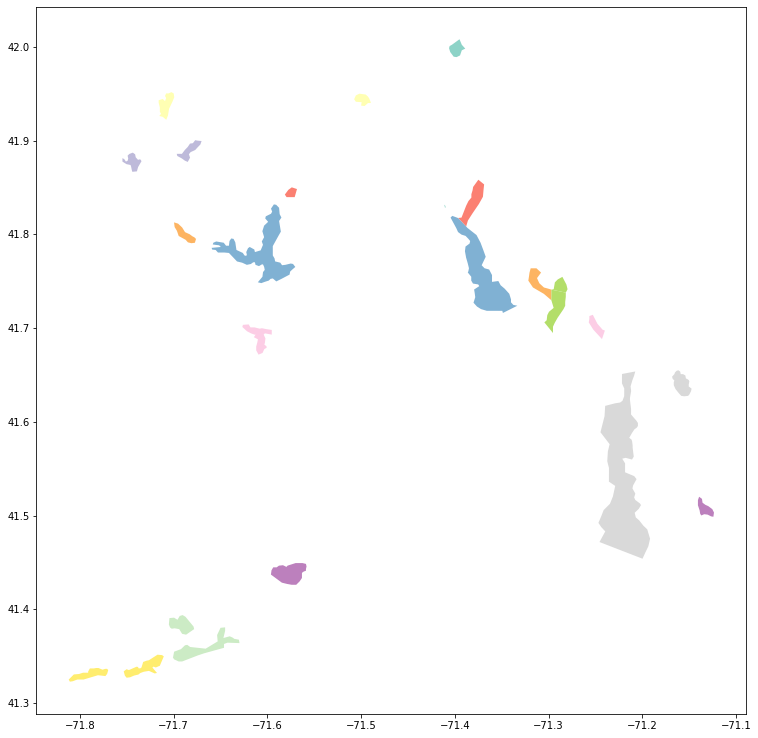

In [14]:
ri_park_water.plot(figsize=(18, 13), cmap="Set3")

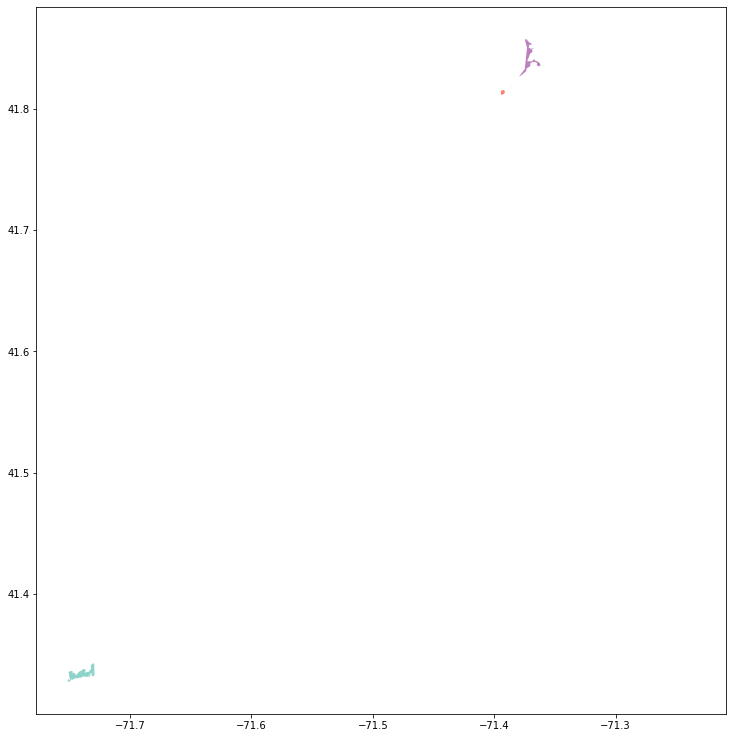

In [15]:
ri_ghost.plot(figsize=(18, 13), cmap="Set3")

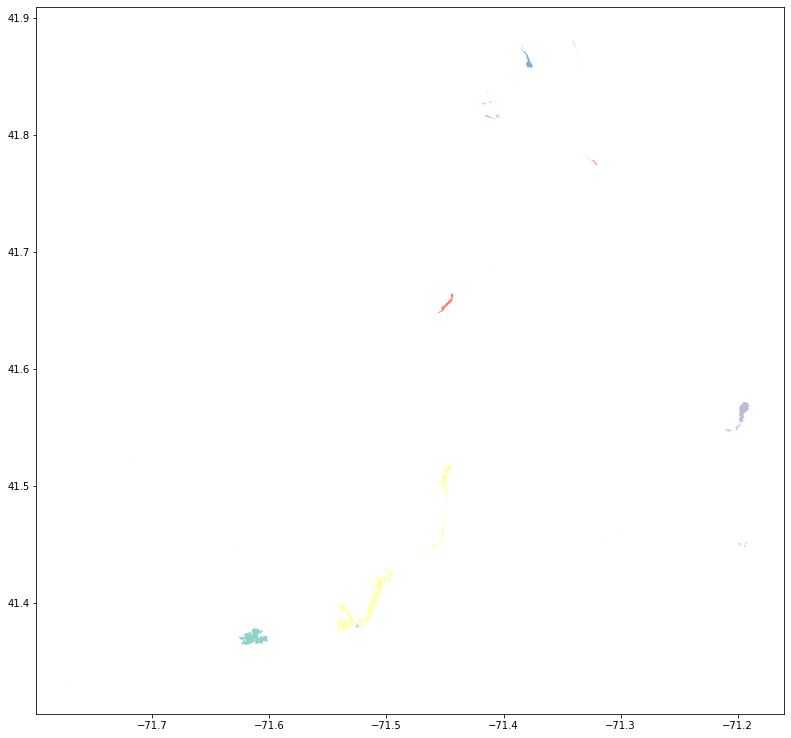

In [16]:
ri_gap.plot(figsize=(18, 13), cmap="Set3")

# classify VA

In [17]:
va_park_water = gpd.overlay(parks["VA"], waters["VA"], how="union")

In [18]:
va_empty = mp2p(va_empty)
len(va_empty)

2596

In [19]:
va_ghost = gpd.GeoDataFrame(columns=["geometry"])
for index, row in va_empty.iterrows():
    g = row["geometry"]
    g_df = va_empty[va_empty["geometry"] == g]
    cur_union = gpd.overlay(g_df, va_park_water, how="intersection")
    if len(cur_union):
        g_area = g.area
        cur_union_area = cur_union.area.sum()
        if cur_union_area >= g_area*0.4:
            va_ghost = va_ghost.append({"geometry":g}, ignore_index=True)
            print("#", end="")

############################################################################################################################################################################################################

In [20]:
# va_ghost = gpd.overlay(va_empty, va_park_water, how='intersection')

In [21]:
va_gap = gpd.overlay(va_empty, va_ghost, how="difference")

In [22]:
va_ghost.to_file("errors/ghost/VA_Ghost.json", driver="GeoJSON")
va_gap.to_file("errors/gap/VA_Gap.json", driver="GeoJSON")

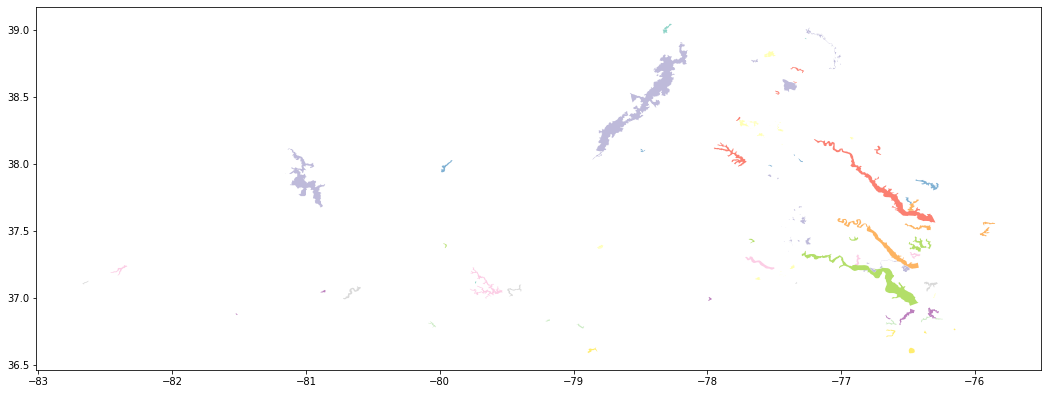

In [23]:
va_park_water.plot(figsize=(18, 13), cmap="Set3")

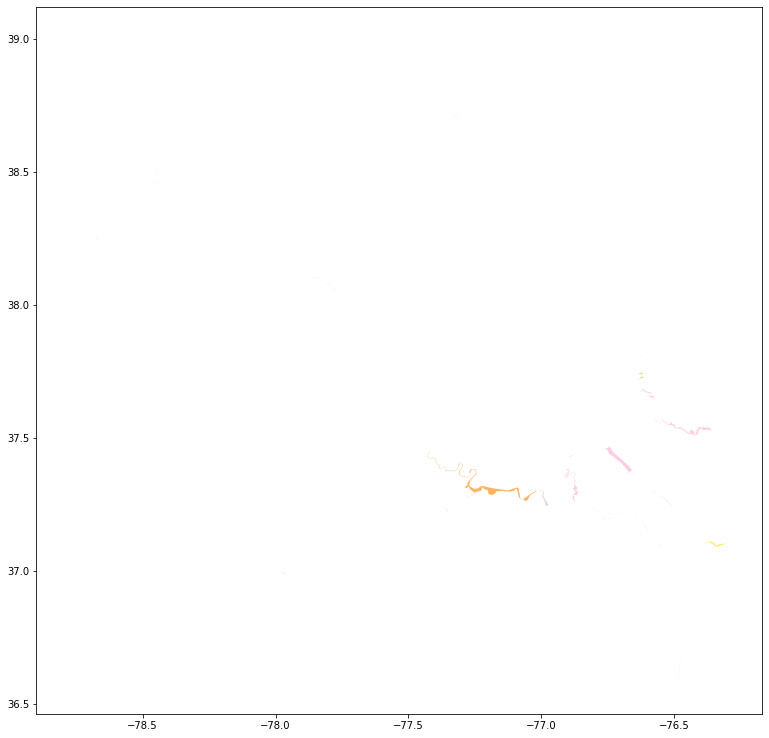

In [24]:
va_ghost.plot(figsize=(18, 13), cmap="Set3")

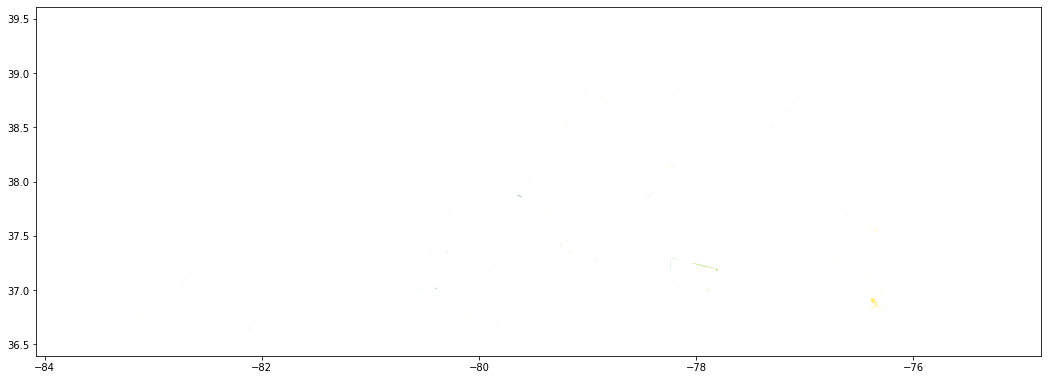

In [25]:
va_gap.plot(figsize=(18, 13), cmap="Set3")

# classify TX

In [26]:
tx_park_water = gpd.overlay(parks["TX"], waters["TX"], how="union")

In [27]:
tx_empty = mp2p(tx_empty)
len(tx_empty)

2085

In [28]:
tx_ghost = gpd.GeoDataFrame(columns=["geometry"])
for index, row in tx_empty.iterrows():
    g = row["geometry"]
    g_df = tx_empty[tx_empty["geometry"] == g]
    cur_union = gpd.overlay(g_df, tx_park_water, how="intersection")
    if len(cur_union):
        g_area = g.area
        cur_union_area = cur_union.area.sum()
        if cur_union_area >= g_area*0.4:
            tx_ghost = tx_ghost.append({"geometry":g}, ignore_index=True)
            print("#", end="")

##########################################################################################################

In [29]:
#tx_ghost = gpd.overlay(tx_empty, tx_park_water, how='intersection')

In [30]:
tx_gap = gpd.overlay(tx_empty, tx_ghost, how="difference")

In [31]:
tx_ghost.to_file("errors/ghost/TX_Ghost.json", driver="GeoJSON")
tx_gap.to_file("errors/gap/TX_Gap.json", driver="GeoJSON")

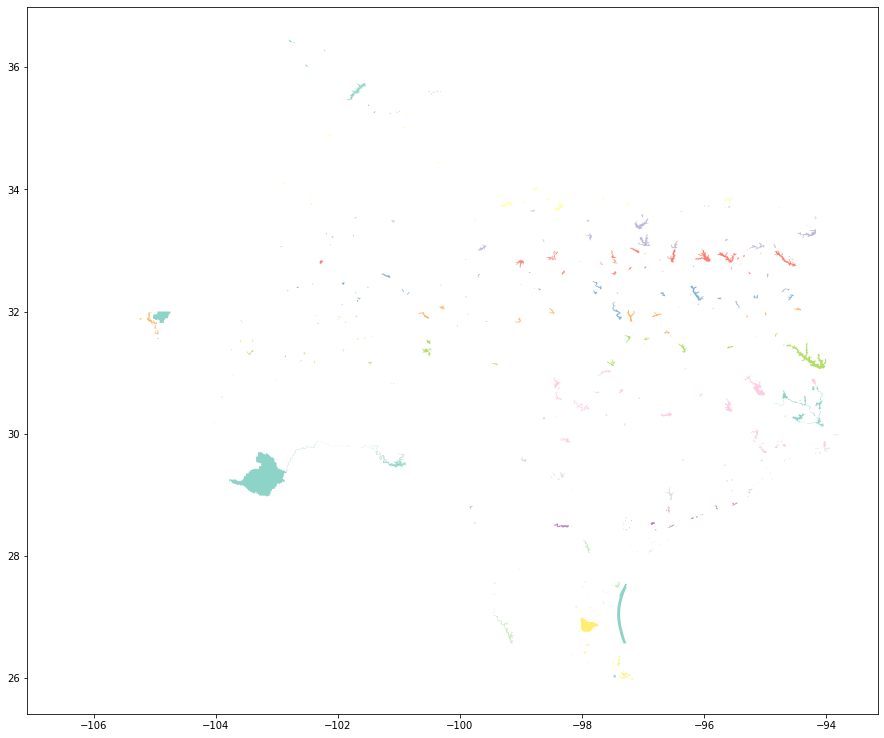

In [32]:
tx_park_water.plot(figsize=(18, 13), cmap="Set3")

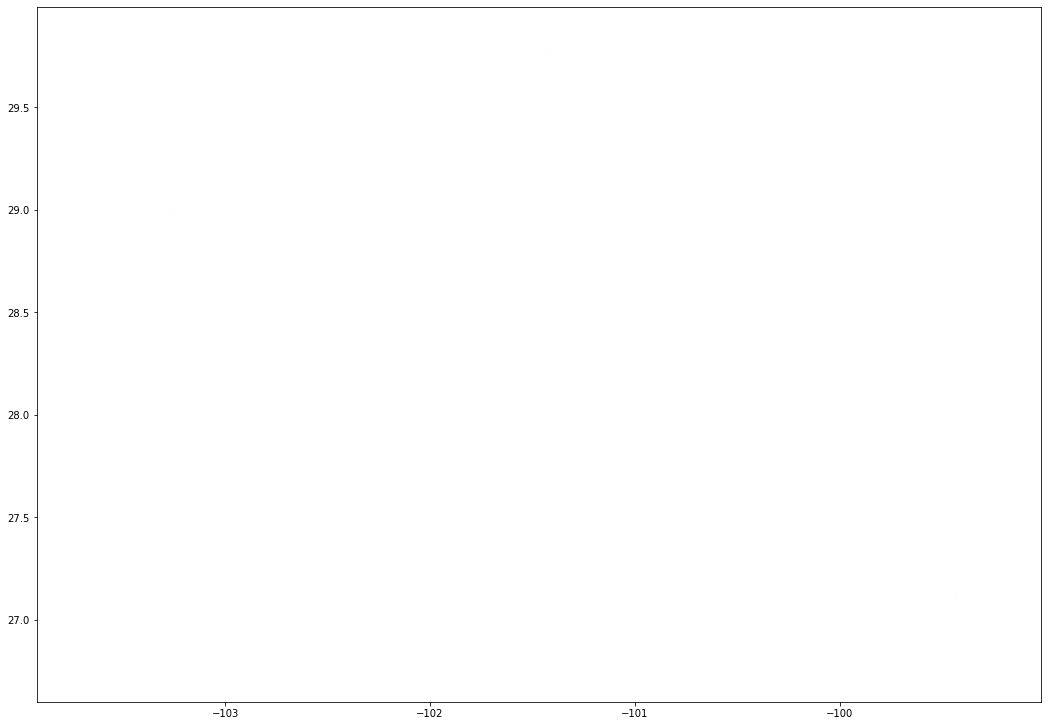

In [33]:
tx_ghost.plot(figsize=(18, 13), cmap="Set3")

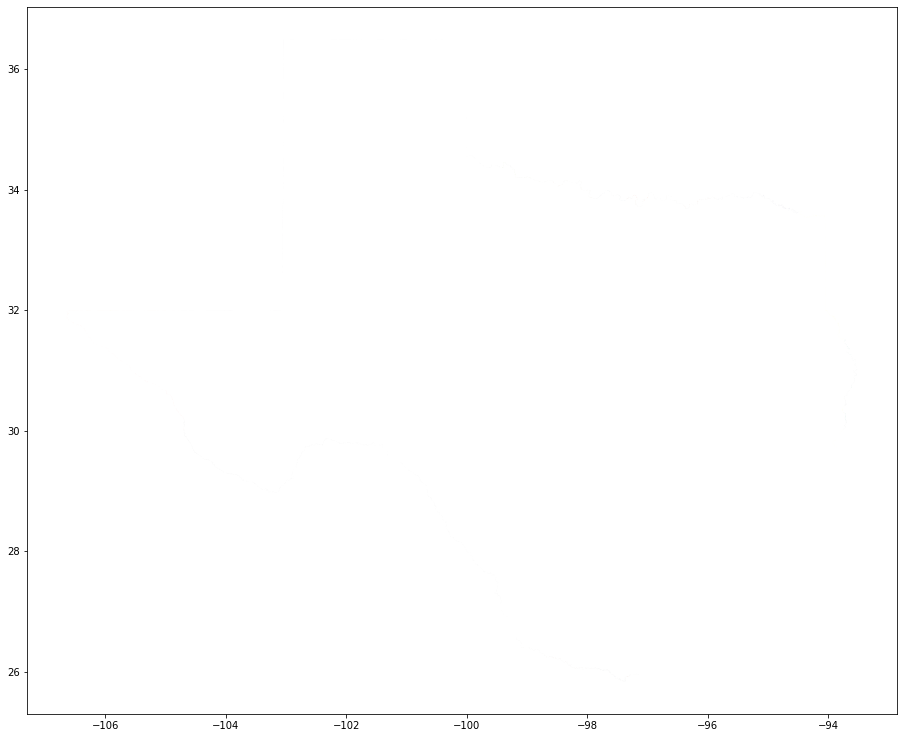

In [34]:
tx_gap.plot(figsize=(18, 13), cmap="Set3")

In [35]:
def decomposeMultipolygon(df, stateid, Type):
    new_df = gpd.GeoDataFrame(columns=["CName", "geometry"])
    counter = 1
    for index, row in df.iterrows():
        g = row["geometry"]
        if g.geom_type == "MultiPolygon":
            for shape in g:
                new_df = new_df.append({"CName":stateid+"-"+Type+"-"+str(counter), "geometry":shape}, ignore_index=True)
                counter += 1
        else:
            new_df = new_df.append({"CName":stateid+"-"+Type+"-"+str(counter), "geometry":g}, ignore_index=True)
            counter += 1
    return new_df

In [36]:
def deleteColumns(df):
    c = list(df.columns)
    c.remove("geometry")
    df.drop(columns=c, axis=1, inplace=True)
    return df

In [37]:
ri_ghost = deleteColumns(ri_ghost)
ri_ghost = decomposeMultipolygon(ri_ghost, "ri", "ghost")
ri_ghost.head()

,CName,geometry
0,ri-ghost-1,"POLYGON ((-71.72988 41.33304, -71.72988 41.333..."
1,ri-ghost-2,"POLYGON ((-71.39445 41.81126, -71.39444 41.814..."
2,ri-ghost-3,"POLYGON ((-71.38648 41.81771, -71.38580 41.818..."
3,ri-ghost-4,"POLYGON ((-71.37480 41.85722, -71.37478 41.857..."
4,ri-ghost-5,"POLYGON ((-71.23518 41.48157, -71.23517 41.481..."


In [38]:
ri_gap = deleteColumns(ri_gap)
ri_gap = decomposeMultipolygon(ri_gap, "ri", "gap")
ri_gap.head()

,CName,geometry
0,ri-gap-1,"POLYGON ((-71.52526 41.38229, -71.52519 41.382..."
1,ri-gap-2,"POLYGON ((-71.76999 41.33280, -71.76997 41.332..."
2,ri-gap-3,"POLYGON ((-71.62413 41.36539, -71.62390 41.366..."
3,ri-gap-4,"POLYGON ((-71.49247 41.42926, -71.49259 41.429..."
4,ri-gap-5,"POLYGON ((-71.44815 41.50284, -71.44819 41.502..."


In [39]:
ri_ghost.to_file("errors/ghost/RI_Ghost_CName.json", driver="GeoJSON")
ri_gap.to_file("errors/gap/RI_Gap_CName.json", driver="GeoJSON")

In [40]:
va_ghost = deleteColumns(va_ghost)
va_ghost = decomposeMultipolygon(va_ghost, "va", "ghost")
va_ghost.head()

,CName,geometry
0,va-ghost-1,"POLYGON ((-78.63862 38.29071, -78.63919 38.290..."
1,va-ghost-2,"POLYGON ((-78.66981 38.24737, -78.66981 38.247..."
2,va-ghost-3,"POLYGON ((-78.61897 38.30346, -78.61810 38.303..."
3,va-ghost-4,"POLYGON ((-78.49940 38.39960, -78.49912 38.400..."
4,va-ghost-5,"POLYGON ((-78.49318 38.40651, -78.49314 38.406..."


In [41]:
va_gap = deleteColumns(va_gap)
va_gap = decomposeMultipolygon(va_gap, "va", "gap")
va_gap.head()

,CName,geometry
0,va-gap-1,"POLYGON ((-82.13715 36.63294, -82.13481 36.634..."
1,va-gap-2,"POLYGON ((-82.12232 36.65820, -82.12189 36.658..."
2,va-gap-3,"POLYGON ((-82.12375 36.65500, -82.12402 36.654..."
3,va-gap-4,"POLYGON ((-82.12651 36.65332, -82.12442 36.650..."
4,va-gap-5,"POLYGON ((-82.12162 36.64628, -82.12065 36.644..."


In [42]:
va_ghost.to_file("errors/ghost/VA_Ghost_CName.json", driver="GeoJSON")
va_gap.to_file("errors/gap/VA_Gap_CName.json", driver="GeoJSON")

In [43]:
tx_ghost = deleteColumns(tx_ghost)
tx_ghost = decomposeMultipolygon(tx_ghost, "tx", "ghost")
tx_ghost.head()

,CName,geometry
0,tx-ghost-1,"POLYGON ((-99.24041 26.75267, -99.24194 26.779..."
1,tx-ghost-2,"POLYGON ((-99.29515 26.86544, -99.31052 26.864..."
2,tx-ghost-3,"POLYGON ((-99.32803 26.88188, -99.32653 26.885..."
3,tx-ghost-4,"POLYGON ((-99.39128 26.95306, -99.39264 26.955..."
4,tx-ghost-5,"POLYGON ((-99.42924 27.09307, -99.43027 27.094..."


In [44]:
tx_gap = deleteColumns(tx_gap)
tx_gap = decomposeMultipolygon(tx_gap, "tx", "gap")
tx_gap.head()

,CName,geometry
0,tx-gap-1,"POLYGON ((-93.51492 31.02570, -93.52231 31.020..."
1,tx-gap-2,"POLYGON ((-93.52855 31.07060, -93.52896 31.069..."
2,tx-gap-3,"POLYGON ((-93.52231 31.02010, -93.52452 31.019..."
3,tx-gap-4,"POLYGON ((-93.52778 30.93285, -93.52615 30.930..."
4,tx-gap-5,"POLYGON ((-93.52726 30.93563, -93.52778 30.932..."


In [45]:
tx_ghost.to_file("errors/ghost/TX_Ghost_CName.json", driver="GeoJSON")
tx_gap.to_file("errors/gap/TX_Gap_CName.json", driver="GeoJSON")